In [417]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import csv
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


***
## **PRE PROCESSING :** ##
***

### **Premier dataset :** *"english_premier_league_data.csv" dont on conserve toutes les features statistiques* ###

In [392]:
df1 = pd.read_csv('Result_dataset/english_premier_league_data.csv', sep=';')
df1 = df1[df1['year'].isin([2016, 2017, 2018, 2019, 2020])] # on se restreint à ces années 
df1 = df1.rename(columns={'year': 'season'})
df1 = df1.drop(["Score","Half Time Score"], axis = 1)
df1.head()

,Home Team,Away Team,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,season
760,HULL CITY,LEICESTER CITY,5.9,6.7,5.4,50,50,7.0,5.0,14.0,2.0,5.0,23.0,76.0,19.0,29.0,8.0,2.0,0.0,0.0,9.0,5.0,18.0,4.0,3.0,16.0,78.0,18.0,15.0,17.0,2.0,0.0,0.0,2,1,1,2,2016
761,EVERTON,TOTTENHAM,4.9,7.0,6.4,42,58,4.0,6.0,12.0,2.0,5.0,21.0,73.0,16.0,40.0,10.0,0.0,0.0,0.0,4.0,4.0,13.0,5.0,6.0,42.0,80.0,10.0,22.0,14.0,0.0,0.0,0.0,1,1,1,1,2016
762,MIDDLESBROUGH,STOKE,4.5,6.4,6.2,46,54,6.0,2.0,12.0,4.0,9.0,20.0,75.0,22.0,20.0,18.0,3.0,0.0,0.0,9.0,1.0,12.0,2.0,6.0,23.0,79.0,27.0,16.0,14.0,5.0,0.0,0.0,1,1,1,1,2016
763,BURNLEY,SWANSEA,4.0,5.1,7.9,47,53,5.0,3.0,10.0,2.0,7.0,41.0,71.0,20.0,16.0,10.0,3.0,0.0,0.0,6.0,9.0,17.0,2.0,4.0,13.0,78.0,32.0,49.0,14.0,2.0,0.0,0.0,0,1,1,0,2016
764,SOUTHAMPTON,WATFORD,4.6,7.0,6.1,64,36,10.0,6.0,24.0,8.0,6.0,25.0,85.0,9.0,21.0,8.0,1.0,0.0,0.0,4.0,1.0,5.0,0.0,2.0,12.0,69.0,19.0,36.0,12.0,2.0,0.0,1.0,1,1,1,1,2016


***
### **Second dataset :** *"spi_matches.csv" dont on extrait certains features* ###

In [393]:
df2 = pd.read_csv('SPI_dataset/spi_matches.csv', sep=';')

df2.dropna()

ligues = ['Barclays Premier League']
df2 = df2[df2['league'].isin(ligues)] # que la Premier League

df2 = df2[df2['season'].isin([2016, 2017, 2018, 2019, 2020])] #on se retreint à ces années
df2 = df2.rename(columns={'team1': 'Home Team', 'team2': 'Away Team', # on renomme les features comme df
                          'score1': 'Home Team Goals Scored', 'score2': 'Away Team Goals Scored', 
                          'xg1': 'Home Team xG', 'xg2': 'Away Team xG',
                          'nsxg1': 'Home Team NSxG', 'nsxg2': 'Away Team NSxG',
                          'spi1': 'Home Team SPI Rate', 'spi2': 'Away Team SPI Rate',
                          'prob1': 'Home Team ProbWin', 'prob2': 'Away Team ProbWin',
                          'proj_score1': 'Home Team ProjScore', 'proj_score2': 'Away Team ProjScore',
                          'adj_score1': 'Home Team AdjScore', 'adj_score2': 'Away Team AdjScore',
                          'importance1': 'Home Team Importance', 'importance2': 'Away Team Importance',
                          })

df2 = df2.drop(['league_id', 'league'], axis = 1)


df2.head()



,season,date,Home Team,Away Team,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team Goals Scored,Away Team Goals Scored,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore
12,2016,2016-08-13,Hull,Leicester,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
13,2016,2016-08-13,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,1.35,1.14,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
14,2016,2016-08-13,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
15,2016,2016-08-13,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,1.91,1.05,34.1,30.7,1.0,1.0,1.05,0.22,1.52,0.41,1.05,1.05
16,2016,2016-08-13,Middlesbrough,Stoke,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,1.05,1.05


In [394]:
data_set_1 = df1["Away Team"].unique() #liste des équipes de df1 sans doublons
data_set_2 = df2["Away Team"].unique() #liste des équipes de df2 sans doublons

In [395]:
fuzz.WRatio("TOTTENHAM","Tottenham Hotspur") # etudie la correspondance des string


90

In [396]:
# on veut identifier les noms d'equipes dans chaque dataframe pour que le merge se fasse correctement

def create_team_dict(data_set_1, data_set_2): #cree dictionnaire avec {nom dataset2 : nom dataset1}
    team_dict = {}
    for team2 in data_set_2:
        for team1 in data_set_1:
            ratio = fuzz.WRatio(team1, team2)
            if ratio >= 87: # ratio de 87 assure la correspondance pour CE dataset
                team_dict[team2] = team1
    return team_dict


In [397]:
team_names = create_team_dict(data_set_1,data_set_2)
df2['Home Team'] = df2['Home Team'].replace(team_names) #remplace nom dataset2 par nom dataset1 
df2['Away Team'] = df2['Away Team'].replace(team_names)
df2.head()

,season,date,Home Team,Away Team,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team Goals Scored,Away Team Goals Scored,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore
12,2016,2016-08-13,HULL CITY,LEICESTER CITY,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
13,2016,2016-08-13,CRYSTAL PALACE,WEST BROM,55.19,58.66,0.4214,0.2939,0.2847,1.35,1.14,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
14,2016,2016-08-13,EVERTON,TOTTENHAM,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
15,2016,2016-08-13,SOUTHAMPTON,WATFORD,69.49,59.33,0.5759,0.1874,0.2367,1.91,1.05,34.1,30.7,1.0,1.0,1.05,0.22,1.52,0.41,1.05,1.05
16,2016,2016-08-13,MIDDLESBROUGH,STOKE,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,1.05,1.05


***
### **FUSION DES DEUX DATAFRAMES** ###

In [398]:
# on merge par le score,les couples d'équipes et l'année 
# ON A DONC NOTRE DATAFRAME PROPRE

df = pd.merge(df1, df2, on=['season', 'Home Team', 'Away Team','Home Team Goals Scored', 'Away Team Goals Scored']) 
df.head()


,Home Team,Away Team,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,season,date,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore
0,HULL CITY,LEICESTER CITY,5.9,6.7,5.4,50,50,7.0,5.0,14.0,2.0,5.0,23.0,76.0,19.0,29.0,8.0,2.0,0.0,0.0,9.0,5.0,18.0,4.0,3.0,16.0,78.0,18.0,15.0,17.0,2.0,0.0,0.0,2,1,1,2,2016,2016-08-13,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,0.85,2.77,0.17,1.25,2.10,1.05
1,EVERTON,TOTTENHAM,4.9,7.0,6.4,42,58,4.0,6.0,12.0,2.0,5.0,21.0,73.0,16.0,40.0,10.0,0.0,0.0,0.0,4.0,4.0,13.0,5.0,6.0,42.0,80.0,10.0,22.0,14.0,0.0,0.0,0.0,1,1,1,1,2016,2016-08-13,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,0.73,1.11,0.88,1.81,1.05,1.05
2,MIDDLESBROUGH,STOKE,4.5,6.4,6.2,46,54,6.0,2.0,12.0,4.0,9.0,20.0,75.0,22.0,20.0,18.0,3.0,0.0,0.0,9.0,1.0,12.0,2.0,6.0,23.0,79.0,27.0,16.0,14.0,5.0,0.0,0.0,1,1,1,1,2016,2016-08-13,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.40,0.55,1.13,1.06,1.05,1.05
3,BURNLEY,SWANSEA,4.0,5.1,7.9,47,53,5.0,3.0,10.0,2.0,7.0,41.0,71.0,20.0,16.0,10.0,3.0,0.0,0.0,6.0,9.0,17.0,2.0,4.0,13.0,78.0,32.0,49.0,14.0,2.0,0.0,0.0,0,1,1,0,2016,2016-08-13,58.98,59.74,0.4482,0.2663,0.2854,1.37,1.05,36.5,29.1,1.24,1.84,1.71,1.56,0.00,1.05
4,SOUTHAMPTON,WATFORD,4.6,7.0,6.1,64,36,10.0,6.0,24.0,8.0,6.0,25.0,85.0,9.0,21.0,8.0,1.0,0.0,0.0,4.0,1.0,5.0,0.0,2.0,12.0,69.0,19.0,36.0,12.0,2.0,0.0,1.0,1,1,1,1,2016,2016-08-13,69.49,59.33,0.5759,0.1874,0.2367,1.91,1.05,34.1,30.7,1.05,0.22,1.52,0.41,1.05,1.05


In [399]:
df.shape

(1900, 54)

***AJOUT DE DEUX COLONNES***

In [400]:
df = df.dropna() 
df["Score Difference"] = df["Home Team Goals Scored"] - df["Away Team Goals Scored"]  # on renseigne l'ecart de score
df["Match Outcome"] = df["Score Difference"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)) # on renseigne l'issue du match (1/0/-1)
#df = pd.get_dummies(df, columns=["Home Team", "Away Team"]).head() # Convertir les attributs catégoriels en attributs numériques


In [401]:
df.head()

,Home Team,Away Team,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,season,date,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore,Score Difference,Match Outcome
0,HULL CITY,LEICESTER CITY,5.9,6.7,5.4,50,50,7.0,5.0,14.0,2.0,5.0,23.0,76.0,19.0,29.0,8.0,2.0,0.0,0.0,9.0,5.0,18.0,4.0,3.0,16.0,78.0,18.0,15.0,17.0,2.0,0.0,0.0,2,1,1,2,2016,2016-08-13,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,0.85,2.77,0.17,1.25,2.10,1.05,1,1
1,EVERTON,TOTTENHAM,4.9,7.0,6.4,42,58,4.0,6.0,12.0,2.0,5.0,21.0,73.0,16.0,40.0,10.0,0.0,0.0,0.0,4.0,4.0,13.0,5.0,6.0,42.0,80.0,10.0,22.0,14.0,0.0,0.0,0.0,1,1,1,1,2016,2016-08-13,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,0.73,1.11,0.88,1.81,1.05,1.05,0,0
2,MIDDLESBROUGH,STOKE,4.5,6.4,6.2,46,54,6.0,2.0,12.0,4.0,9.0,20.0,75.0,22.0,20.0,18.0,3.0,0.0,0.0,9.0,1.0,12.0,2.0,6.0,23.0,79.0,27.0,16.0,14.0,5.0,0.0,0.0,1,1,1,1,2016,2016-08-13,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.40,0.55,1.13,1.06,1.05,1.05,0,0
3,BURNLEY,SWANSEA,4.0,5.1,7.9,47,53,5.0,3.0,10.0,2.0,7.0,41.0,71.0,20.0,16.0,10.0,3.0,0.0,0.0,6.0,9.0,17.0,2.0,4.0,13.0,78.0,32.0,49.0,14.0,2.0,0.0,0.0,0,1,1,0,2016,2016-08-13,58.98,59.74,0.4482,0.2663,0.2854,1.37,1.05,36.5,29.1,1.24,1.84,1.71,1.56,0.00,1.05,-1,-1
4,SOUTHAMPTON,WATFORD,4.6,7.0,6.1,64,36,10.0,6.0,24.0,8.0,6.0,25.0,85.0,9.0,21.0,8.0,1.0,0.0,0.0,4.0,1.0,5.0,0.0,2.0,12.0,69.0,19.0,36.0,12.0,2.0,0.0,1.0,1,1,1,1,2016,2016-08-13,69.49,59.33,0.5759,0.1874,0.2367,1.91,1.05,34.1,30.7,1.05,0.22,1.52,0.41,1.05,1.05,0,0


***
## **DATA VISUALIZATION :** ## 
***


In [402]:
# df.mean()
df.describe()

,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,season,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore,Score Difference,Match Outcome
count,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000
mean,5.356022,6.417634,6.219462,51.205376,48.794624,5.220430,4.664516,13.582796,3.710215,5.693548,21.896237,78.311290,18.459677,20.514516,10.625269,1.579570,0.018280,0.031183,4.310753,3.933333,11.260753,3.032796,4.670968,21.125806,77.194086,18.418817,24.291935,10.785484,1.706989,0.027419,0.037097,1.509677,1.236022,1.236022,1.509677,2018.034946,70.243022,70.208011,0.450575,0.313657,0.235770,1.572247,1.225075,35.156882,33.984946,1.554419,1.277753,1.540952,1.268704,1.513833,1.246161,0.273656,0.123118
std,1.671004,0.999731,0.994848,13.080903,13.080903,2.697161,2.655660,5.680968,2.542041,3.065830,6.210620,7.743771,7.461429,9.654399,3.431792,1.235399,0.133997,0.179940,2.365748,2.343055,4.948065,2.219891,2.736464,6.253071,7.757241,7.345055,10.575339,3.526234,1.266379,0.163346,0.200108,1.307245,1.211694,1.211694,1.307245,1.399441,11.899772,11.870684,0.201254,0.184270,0.051434,0.529095,0.518683,26.921977,26.290215,0.904864,0.797673,0.802357,0.674579,1.275003,1.182354,1.913924,0.871769
min,1.700000,2.400000,1.500000,18.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,51.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,48.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,42.970000,43.510000,0.028300,0.008000,0.053100,0.410000,0.200000,0.000000,0.000000,0.000000,0.000000,0.050000,0.030000,0.000000,0.000000,-9.000000,-1.000000
25%,4.100000,5.700000,5.500000,42.000000,39.000000,3.000000,3.000000,10.000000,2.000000,3.000000,18.000000,73.000000,13.000000,14.000000,8.000000,1.000000,0.000000,0.000000,3.000000,2.000000,8.000000,1.000000,3.000000,17.000000,72.000000,13.000000,17.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2017.000000,60.870000,60.580000,0.315500,0.185700,0.209900,1.217500,0.887500,12.050000,10.700000,0.850000,0.680000,0.980000,0.780000,1.050000,0.000000,-1.000000,-1.000000
50%,5.300000,6.400000,6.200000,51.000000,49.000000,5.000000,4.000000,13.000000,3.000000,5.000000,21.000000,79.000000,18.000000,19.000000,10.000000,1.000000,0.000000,0.000000,4.000000,4.000000,11.000000,3.000000,4.000000,21.000000,78.000000,18.000000,23.000000,11.000000,2.000000,0.000000,0.0000

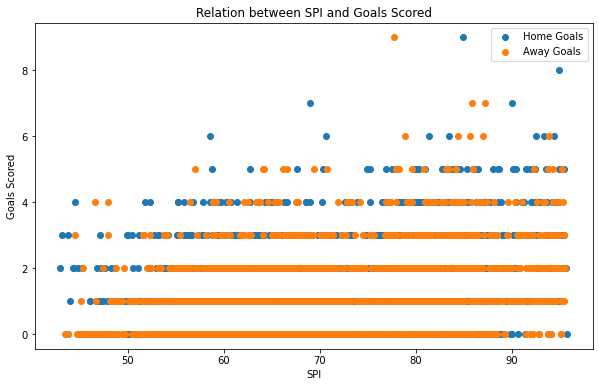

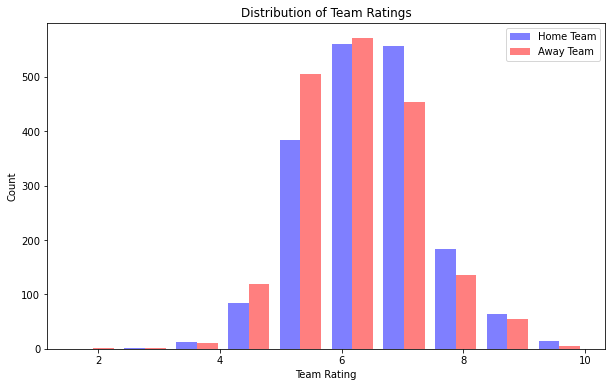

In [420]:
# Tracer le diagramme en nuage de points
plt.subplots(figsize=(10, 6))
plt.scatter(df['Home Team SPI Rate'], df['Home Team Goals Scored'], label='Home Goals')
plt.scatter(df['Away Team SPI Rate'], df['Away Team Goals Scored'], label='Away Goals')

# Ajouter des titres et des légendes
plt.title('Relation between SPI and Goals Scored')
plt.xlabel('SPI')
plt.ylabel('Goals Scored')
plt.legend()

# Afficher le graphique
plt.show()


#####
plt.subplots(figsize=(10, 6))
plt.hist([df['Home Team Rating'], df['Away Team Rating']], color=['blue', 'red'], alpha=0.5, bins=10)
plt.xlabel('Team Rating')
plt.ylabel('Count')
plt.title('Distribution of Team Ratings')
plt.legend(['Home Team', 'Away Team'])
plt.show()



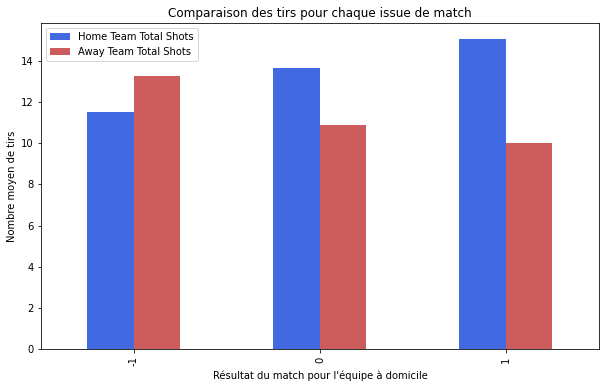

In [ ]:
import matplotlib.pyplot as plt
# Créer un graphique en barres pour comparer les tirs de chaque équipe pour chaque issue de match

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby('Match Outcome').agg({'Home Team Total Shots': 'mean', 'Away Team Total Shots': 'mean'}).plot(kind='bar', ax=ax, color=['royalblue', 'indianred'])
ax.set_xlabel('Résultat du match pour l\'équipe à domicile')
ax.set_ylabel('Nombre moyen de tirs')
ax.set_title('Comparaison des tirs pour chaque issue de match')
plt.show()


In [386]:
df.head()

,Home Team,Away Team,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,season,date,Home Team SPI Rate,Away Team SPI Rate,Home Team ProbWin,Away Team ProbWin,probtie,Home Team ProjScore,Away Team ProjScore,Home Team Importance,Away Team Importance,Home Team xG,Away Team xG,Home Team NSxG,Away Team NSxG,Home Team AdjScore,Away Team AdjScore,Score Difference,Match Outcome
0,HULL CITY,LEICESTER CITY,5.9,6.7,5.4,50,50,7.0,5.0,14.0,2.0,5.0,23.0,76.0,19.0,29.0,8.0,2.0,0.0,0.0,9.0,5.0,18.0,4.0,3.0,16.0,78.0,18.0,15.0,17.0,2.0,0.0,0.0,2,1,1,2,2016,2016-08-13,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,0.85,2.77,0.17,1.25,2.10,1.05,1,1
1,EVERTON,TOTTENHAM,4.9,7.0,6.4,42,58,4.0,6.0,12.0,2.0,5.0,21.0,73.0,16.0,40.0,10.0,0.0,0.0,0.0,4.0,4.0,13.0,5.0,6.0,42.0,80.0,10.0,22.0,14.0,0.0,0.0,0.0,1,1,1,1,2016,2016-08-13,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,0.73,1.11,0.88,1.81,1.05,1.05,0,0
2,MIDDLESBROUGH,STOKE,4.5,6.4,6.2,46,54,6.0,2.0,12.0,4.0,9.0,20.0,75.0,22.0,20.0,18.0,3.0,0.0,0.0,9.0,1.0,12.0,2.0,6.0,23.0,79.0,27.0,16.0,14.0,5.0,0.0,0.0,1,1,1,1,2016,2016-08-13,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.40,0.55,1.13,1.06,1.05,1.05,0,0
3,BURNLEY,SWANSEA,4.0,5.1,7.9,47,53,5.0,3.0,10.0,2.0,7.0,41.0,71.0,20.0,16.0,10.0,3.0,0.0,0.0,6.0,9.0,17.0,2.0,4.0,13.0,78.0,32.0,49.0,14.0,2.0,0.0,0.0,0,1,1,0,2016,2016-08-13,58.98,59.74,0.4482,0.2663,0.2854,1.37,1.05,36.5,29.1,1.24,1.84,1.71,1.56,0.00,1.05,-1,-1
4,SOUTHAMPTON,WATFORD,4.6,7.0,6.1,64,36,10.0,6.0,24.0,8.0,6.0,25.0,85.0,9.0,21.0,8.0,1.0,0.0,0.0,4.0,1.0,5.0,0.0,2.0,12.0,69.0,19.0,36.0,12.0,2.0,0.0,1.0,1,1,1,1,2016,2016-08-13,69.49,59.33,0.5759,0.1874,0.2367,1.91,1.05,34.1,30.7,1.05,0.22,1.52,0.41,1.05,1.05,0,0


***
### **ENCODAGE :** ###
***

In [387]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

# encodeur sur les noms des équipes
encoder.fit(df[["Home Team", "Away Team"]])

# transformation des noms des équipes en nombres
df[["Home Team", "Away Team"]] = encoder.transform(df[["Home Team", "Away Team"]])
df[["Home Team", "Away Team"]].head()

,Home Team,Away Team
0,11.0,13.0
1,8.0,25.0
2,17.0,22.0
3,4.0,24.0
4,21.0,26.0


---
---
---

In [415]:


#on copie de df pour faire un autre pour chaque équipe
df_matches = df

df_teams = pd.DataFrame()


for team in df_matches["Home Team"].unique(): # on boucle sur chaque équipe unique 

    df_current_team = pd.DataFrame()  # on prend un nouveau DataFrame pour l'équipe courante de la boucle 

    df_home_matches = df_matches[df_matches["Home Team"] == team] # match à domicile de l'équipe courante
    df_away_matches = df_matches[df_matches["Away Team"] == team] # match à l'exterieur de l'équipe courante
    df_all_matches = pd.concat([df_home_matches, df_away_matches]) # on assemble pour avoir tous les matchs de l'équipe courante


    df_current_team["Team"] = [team]

    # on crée une colonne average pour chaque features (*)
    average_possession = (df_home_matches["Home Team Possession %"].mean() + df_away_matches["Away Team Possession %"].mean()) / 2
    df_current_team["Average Possession"] = average_possession

    # Features à calculer la moyenne pour chaque équipe
    featuresHA = ["Goals Scored", "Goals Conceeded", "xG", "NSxG", "Total Shots", "Off Target Shots", "On Target Shots", "Blocked Shots", "Pass Success %", 
            "Corners", "Throw Ins", "Aerials Won", "Clearances", 
            "Fouls", "Yellow Cards", "Second Yellow Cards", "Red Cards", "Throw Ins", "Importance", "ProjScore", "AdjScore", "SPI Rate", "ProbWin"]

    # on repete le processus (*) pour chaque feature de type ("Home Team" ou "Away Team")
    for feature in featuresHA:
        home_feature_mean = df_home_matches["Home Team " + feature].mean()  # moyenne pour les matchs à domicile
        away_feature_mean = df_away_matches["Away Team " + feature].mean()  # moyenne pour les matchs à l'extérieur

        avg_feature = (home_feature_mean + away_feature_mean) / 2 # moyenne pour tous les matchs
        df_current_team["Average " + feature] = avg_feature

    # on fait la même chose pour les issues de match et la différence de buts
    features = ["Match Outcome", "Score Difference"]
    
    for feature in features:

        home_feature_mean = df_home_matches[feature].mean()  # moyenne pour les matchs à domicile
        away_feature_mean = df_away_matches[feature].mean()  # moyenne pour les matchs à l'extérieur

        avg_feature = (home_feature_mean - away_feature_mean) / 2 # moyenne pour tous les matchs (on fait bien - pour inverser les -1 des victoires à l'extérieur)
        df_current_team["Average " + feature] = avg_feature

    
    
    df_teams = pd.concat([df_teams, df_current_team], ignore_index=True) # on ajoute la ligne pour l'équipe courante au DF de toutes les équipes


In [416]:
df_teams.sort_values("Team")

,Team,Average Possession,Average Goals Scored,Average Goals Conceeded,Average xG,Average NSxG,Average Total Shots,Average Off Target Shots,Average On Target Shots,Average Blocked Shots,Average Pass Success %,Average Corners,Average Throw Ins,Average Aerials Won,Average Clearances,Average Fouls,Average Yellow Cards,Average Second Yellow Cards,Average Red Cards,Average Importance,Average ProjScore,Average AdjScore,Average SPI Rate,Average ProbWin,Average Match Outcome,Average Score Difference
8,ARSENAL,57.270979,1.749766,1.233462,1.631605,1.859326,12.975806,4.743338,4.731300,3.512038,83.187997,5.736033,19.871085,14.884292,19.664095,10.295407,1.740825,0.016187,0.075736,44.308006,1.797868,1.745293,80.276357,0.499393,0.204009,0.516304
26,ASTON VILLA,45.811522,1.281294,1.507112,1.383578,1.272368,12.714083,4.858108,4.415007,3.467283,76.756757,5.380512,20.579659,18.467639,20.581437,11.645448,1.799431,0.066856,0.000000,37.907788,1.236067,1.294705,68.890235,0.310568,-0.145804,-0.225818
7,BOURNEMOUTH,47.573243,1.276486,1.730000,1.319046,1.313114,11.556667,4.406216,3.967658,3.196216,76.796757,5.276306,21.764685,18.176486,26.503063,9.348198,1.624775,0.033604,0.013423,22.282937,1.243931,1.280244,62.328902,0.299113,-0.193243,-0.453514
20,BRIGHTON,47.276316,0.973684,1.407895,1.191382,1.207303,11.197368,4.730263,3.361842,3.105263,77.000000,4.710526,21.671053,18.782895,21.453947,11.105263,1.447368,0.026316,0.065789,25.067763,1.063355,0.998618,63.984276,0.281812,-0.197368,-0.434211
3,BURNLEY,41.462649,1.047872,1.402209,1.132214,1.166517,10.043079,4.220072,3.325345,2.513795,69.260346,4.220072,21.648702,24.866904,26.919278,10.135434,1.688684,0.005495,0.010989,21.198340,1.079697,1.062717,63.371404,0.284560,-0.120178,-0.354337
25,CARDIFF,34.842105,0.894737,1.815789,1.086316,1.078421,10.973684,4.710526,3.315789,3.000000,63.236842,4.421053,21.026316,25.815789,25.736842,9.842105,1.736842,0.000000,0.026316,47.973684,1.021053,0.922368,58.423684,0.247026,-0.368421,-0.921053
9,CHELSEA,59.376344,1.774194,1.043011,1.785968,1.918602,15.655914,5.564516,5.548387,4.543011,85.102151,5.994624,20.505376,15.489247,17.704301,10.112903,1.440860,0.016129,0.021505,65.274731,1.929677,1.771452,84.967527,0.584680,0.349462,0.731183
5,CRYSTAL PALACE,44.039350,1.149623,1.496397,1.186126,1.270318,11.252745,4.532887,3.632578,3.108671,74.438744,4.976436,22.136067,19.548216,23.587337,11.089682,1.716255,0.010638,0.021391,20.924897,1.132987,1.145665,64.705635,0.291899,-0.138927,-0.346774
1,EVERTON,49.080188,1.311370,1.335907,1.357676,1.288334,11.700812,4.483070,4.162034,3.077099,77.177362,4.858842,21.578014,20.166266,24.340254,11.640814,1.646648,0.031972,0.031972,15.027906,1.317620,1.315378,70.429949,0.359585,0.027740,-0.024537
23,FULHAM,49.289474,0.802632,1.763158,1.096974,1.193947,11.789474,5.000000,3.697368,3.092105,79.684211,4.276316,20.381579,18.197368,22.421053,11.921053,1.802632,0.026316,0.039474,37.500000,1.075921,0.835395,62.520263,0.265237,-0.447368,-0.960526


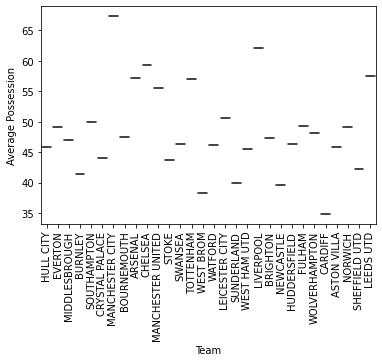

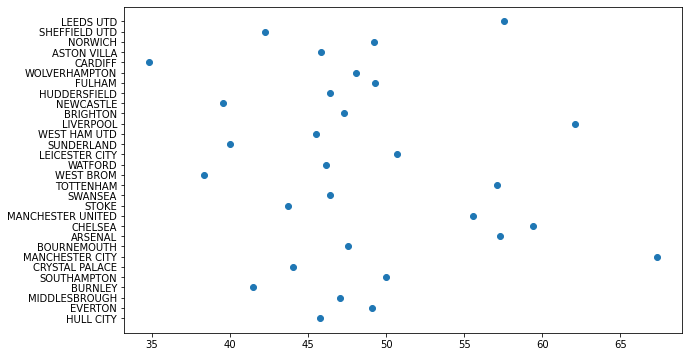

In [433]:
sns.boxplot(x="Team", y="Average Possession", data=df_teams)
plt.xticks(rotation=90)
plt.show()
plt.subplots(figsize=(10, 6))
plt.scatter(x="Average Possession", y="Team", data=df_teams)
plt.show()


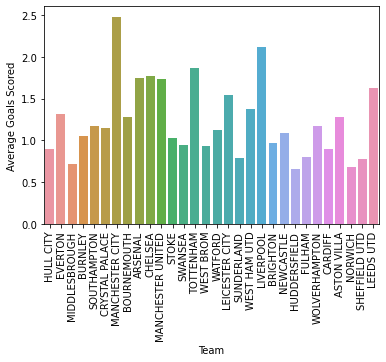

In [428]:
sns.barplot(x="Team", y="Average Goals Scored", data=df_teams)

plt.xticks(rotation=90)
plt.show()


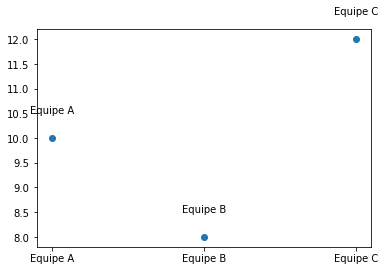

In [430]:
import matplotlib.pyplot as plt

# Données de l'exemple
equipes = ['Equipe A', 'Equipe B', 'Equipe C']
scores = [10, 8, 12]

# Créer le graphique en barres
plt.scatter(equipes, scores)

# Ajouter le nom de chaque équipe
for i in range(len(equipes)):
    plt.text(i, scores[i] + 0.5, equipes[i], ha='center')

# Afficher le graphique
plt.show()
